# Import Packages

In [21]:
import numpy as np
import pandas as pd
# import keras
import sklearn
import pickle
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Miscellaneous

In [22]:
class Timer(object):
    """Create a Timer, Record the time gap"""
    def __init__(self):
        self.times=[]
        self.start()
        
    def start(self):
        # record the timestamp of start
        self.tik = time.time()
        
    def stop(self):
        # record the time gap from start to stop
        self.times.append(time.time() - self.tik)
        
    def avg(self):
        return sum(self.times) / len(self.times)
    
    def sum(self):
        return sum(self.times)
    
    def cumsum(self):
        return np.array(self.times).cumsum().tolist()
    
def Binarization(x):
    """Binarization of Grayscale Images"""
    if x == 0:
        return 0
    else:
        return 1

# Load dataset

In [23]:
# 数据集的相对地址
dataset_train_dir = './EMNIST_Byclass_Small/emnist_train.pkl'
dataset_test_dir = './EMNIST_Byclass_Small/emnist_test.pkl'

# 将数据集文件解压缩，读取为字典（按照dataset_description.txt文件所示）
dataset_train_dict = pickle.load(file=open(dataset_train_dir, 'rb'))
dataset_test_dict = pickle.load(file=open(dataset_test_dir, 'rb'))


# SVM

In [40]:
from sklearn import svm

# 将训练集由形状(100000, 28, 28)转为形状(100000, 28**2)
x_train = dataset_train_dict['data'].reshape(100000, 28**2).astype('float32')
y_train = dataset_train_dict['labels']

# 将训练集由形状(20000, 28, 28)转为形状(20000, 28**2)
x_test = dataset_test_dict['data'].reshape(20000, 28**2).astype('float32')
y_test = dataset_test_dict['labels']

# 数据归一化
x_train = x_train / 255
x_test = x_test / 255

# 创建模型svm
# C：正则化参数
# kernel：SVM使用的内核函数，‘rbf’为径向基函数内核
# gamma：内核函数的核系数
# model = svm.SVC(C=100.0, kernel='rbf', gamma=0.03)
model = svm.SVC(C=100.0, kernel='rbf', gamma='scale')

# 利用训练集拟合
model.fit(x_train, y_train)

SVC(C=100.0, gamma=0.03)

In [41]:
# 利用测试集评估预测精度
predictions = [int(a) for a in model.predict(x_test)]
print('accuracy=', accuracy_score(y_test, predictions))
# 混淆矩阵
print(confusion_matrix(y_test, predictions))
# f1-score,precision,recall
print(classification_report(y_test, np.array(predictions)))

accuracy= 0.8179
[[700   0   0 ...   0   0   0]
 [  0 799   2 ...   0   0   0]
 [  0   0 971 ...   0   0   5]
 ...
 [  0   0   1 ...  60   1   0]
 [  0   0   0 ...   0  14   0]
 [  0   0  27 ...   1   0  31]]
              precision    recall  f1-score   support

           0       0.63      0.72      0.67       976
           1       0.65      0.78      0.71      1023
           2       0.90      0.97      0.93      1003
           3       0.96      0.98      0.97      1035
           4       0.91      0.96      0.93       903
           5       0.88      0.90      0.89       928
           6       0.95      0.97      0.96       959
           7       0.98      0.98      0.98      1098
           8       0.92      0.97      0.95       941
           9       0.91      0.96      0.94       929
          10       0.88      0.88      0.88       170
          11       0.86      0.69      0.77       118
          12       0.75      0.81      0.78       316
          13       0.84      0.77 

# 决策树分类

In [45]:
# 将训练集由形状(100000, 28, 28)转为形状(100000, 28**2)
x_train = dataset_train_dict['data'].reshape(100000, 28**2).astype('float32')
y_train = dataset_train_dict['labels']
y_train = y_train.reshape(-1, 1)

# 将训练集由形状(20000, 28, 28)转为形状(20000, 28**2)
x_test = dataset_test_dict['data'].reshape(20000, 28**2).astype('float32')
y_test = dataset_test_dict['labels']
y_test = y_test.reshape(-1, 1)

# 建立Dataframe
train_data = np.hstack((x_train, y_train))
train_data = pd.DataFrame(train_data)
x_train = train_data.iloc[:, :-1]
print('x_train Shape:', x_train.shape)
y_train = train_data.iloc[:,-1]
print("y_train Shape: ", y_train.shape)

test_data = np.hstack((x_test, y_test))
test_data = pd.DataFrame(test_data)
x_test = test_data.iloc[:, :-1]
print('x_test Shape:', x_test.shape)
y_test = test_data.iloc[:,-1]
print("y_test Shape: ", y_test.shape)

x_train Shape: (100000, 784)
y_train Shape:  (100000,)
x_test Shape: (20000, 784)
y_test Shape:  (20000,)


Sum Axis-1 as Classification accuracy:60.099999999999994


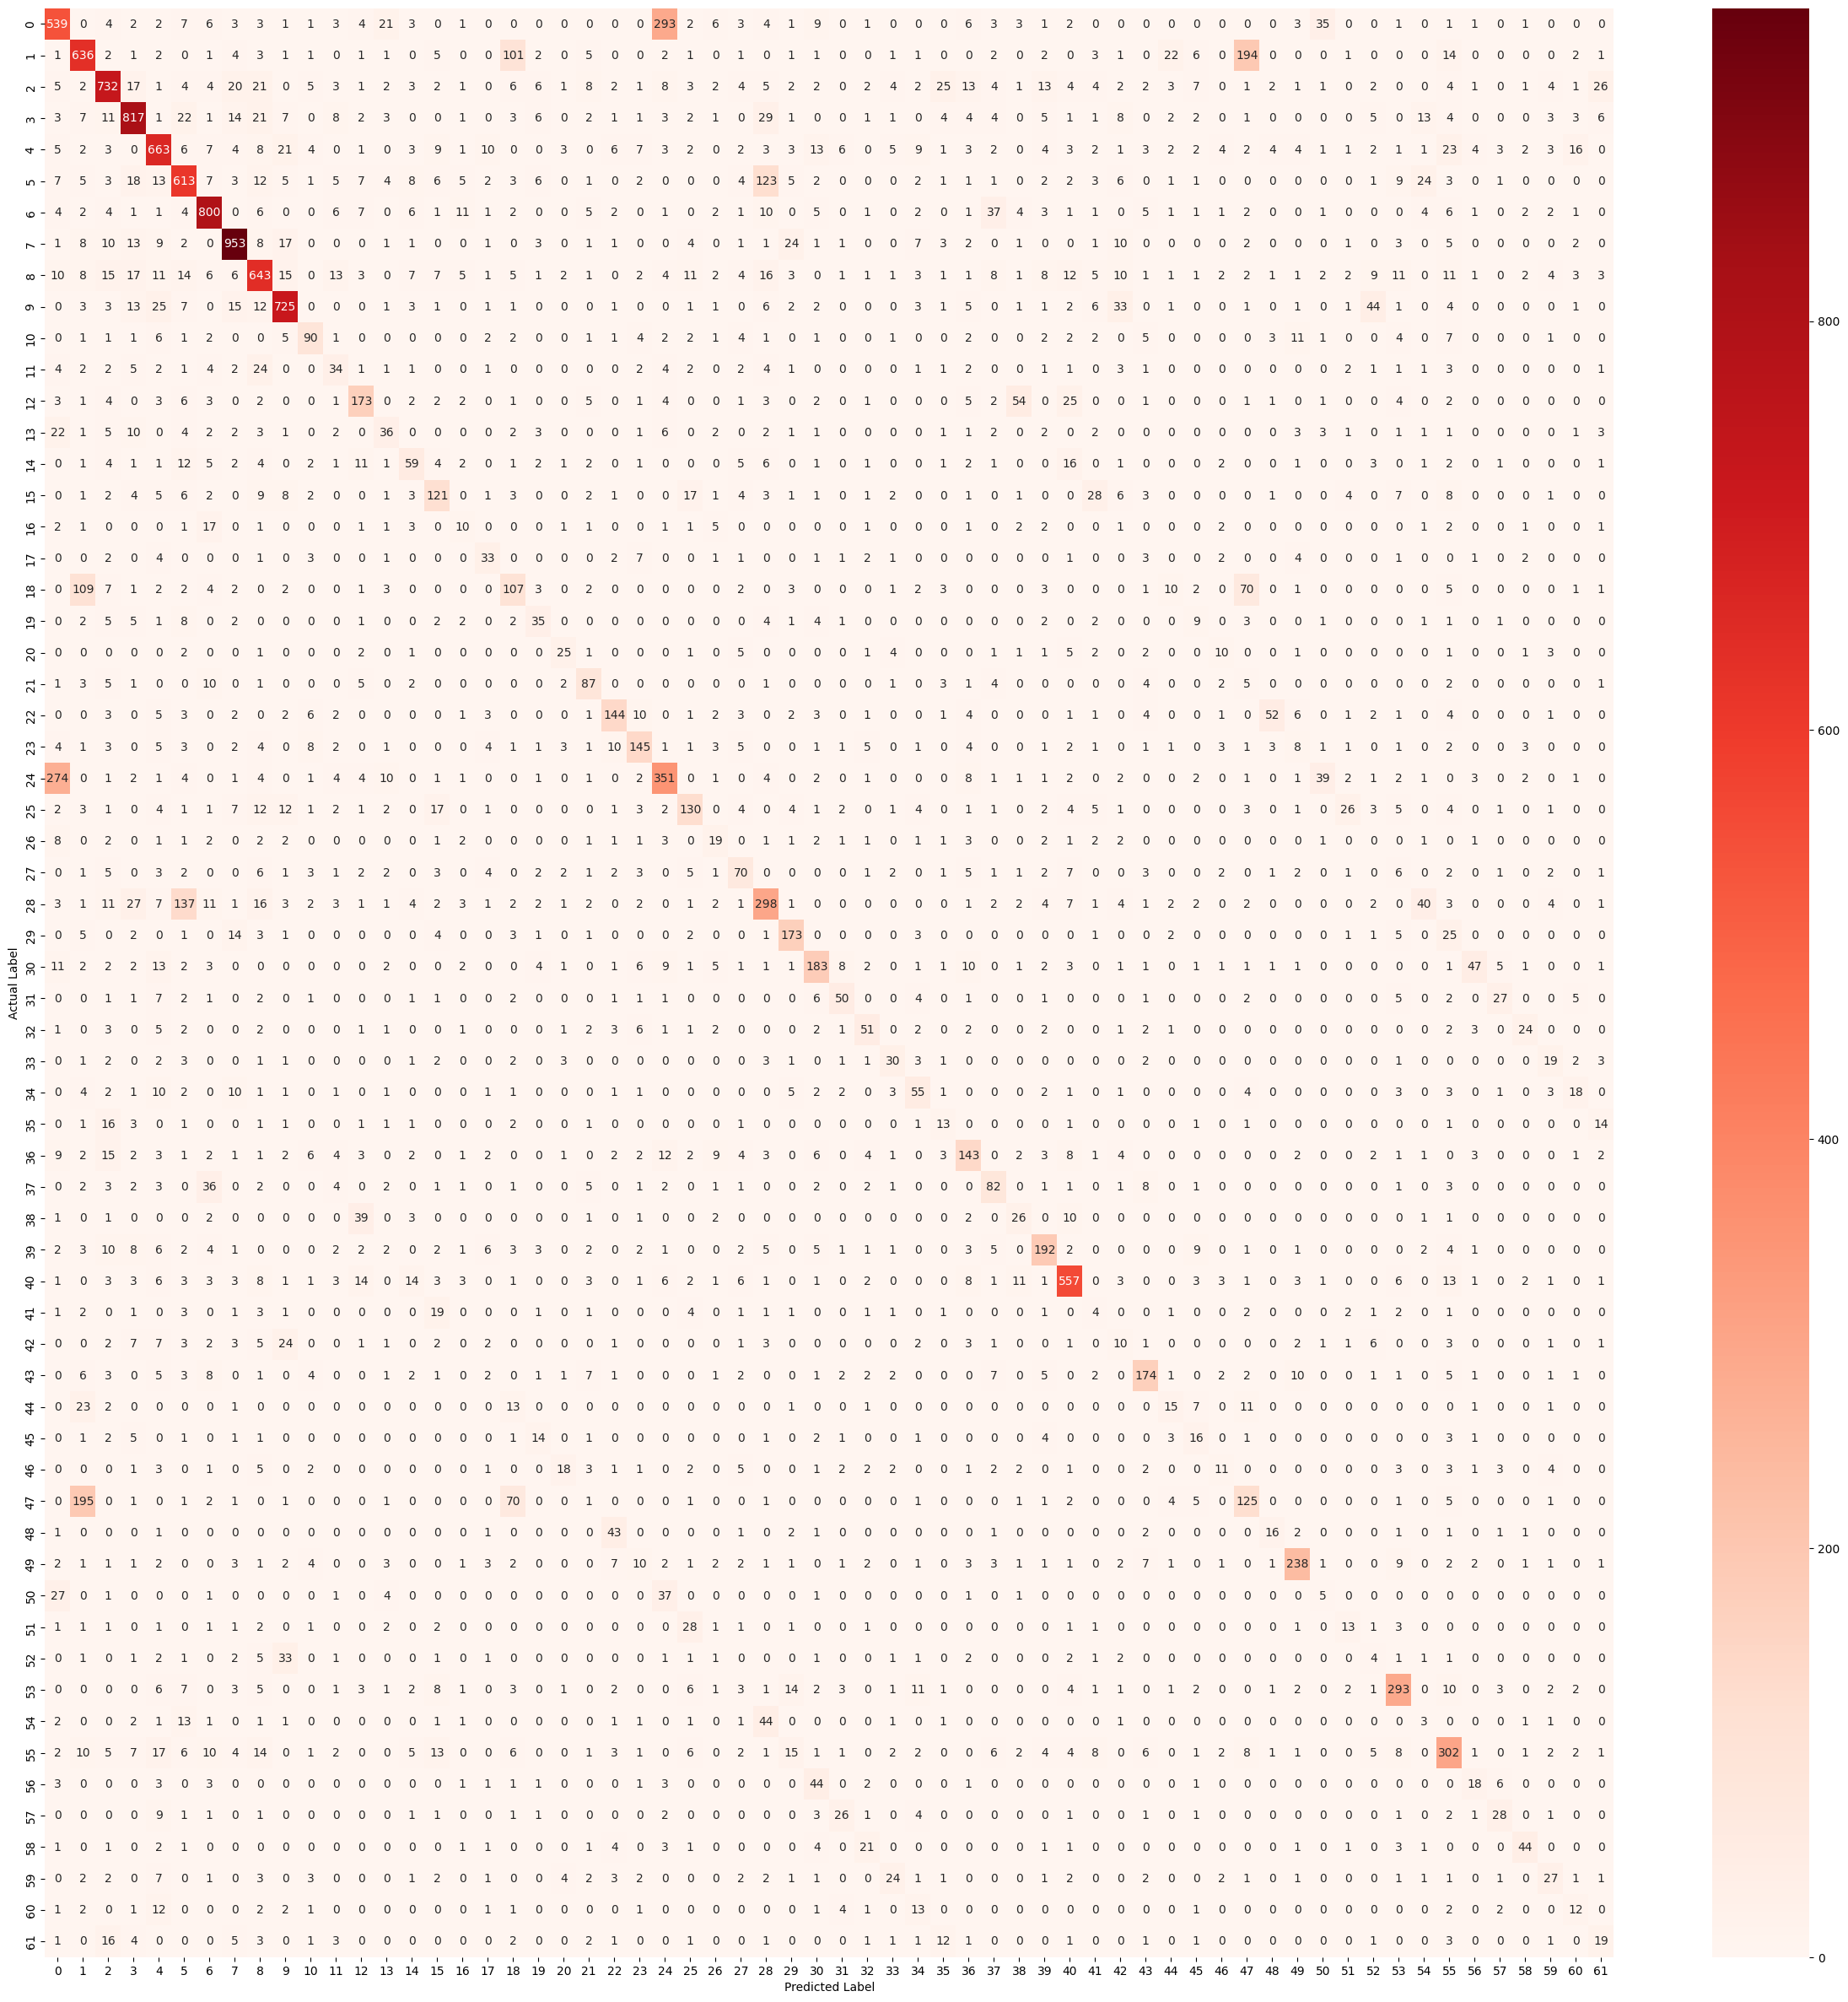

In [33]:
# Create Model of DecisionTreeClassifier
DTmodel = DecisionTreeClassifier()
# Model fitting
DTmodel.fit(x_train, y_train)

# Predict
prediction = DTmodel.predict(x_test)

plt.figure(figsize=(30, 30))
cm = confusion_matrix(y_test, prediction)

ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Reds")
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')

acc = accuracy_score(y_test, prediction)
print(f"Sum Axis-1 as Classification accuracy:{acc * 100}")

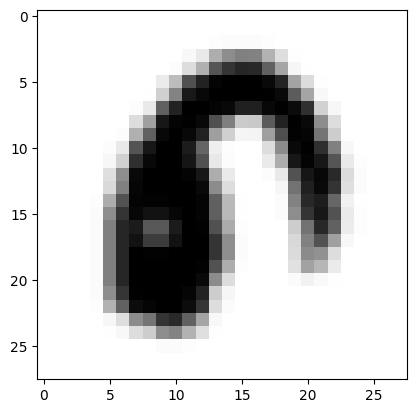

In [50]:
def print_testimage(index, dataset):   
    some_digit = dataset.iloc[index].values  # 按照索引取出图片
    some_digit_img = some_digit.reshape(28,28)  
    plt.imshow(some_digit_img,'binary')  # 展示
    
print_testimage(100, x_train)


In [36]:
from sklearn.model_selection import GridSearchCV

parameters = {'splitter':('best','random')
              ,'criterion':("gini","entropy")
              ,"max_depth":[*range(1,10)]
              ,'min_samples_leaf':[*range(1,50,1)]
}
model = DecisionTreeClassifier()

## 进行网格搜索
clf = GridSearchCV(model, parameters, cv=3, scoring='accuracy',verbose=3, n_jobs=-1)
clf = clf.fit(x_train, y_train)

Fitting 3 folds for each of 1764 candidates, totalling 5292 fits
[CV 3/3] END criterion=gini, max_depth=1, min_samples_leaf=1, splitter=random;, score=0.101 total time=   3.2s
[CV 1/3] END criterion=gini, max_depth=1, min_samples_leaf=2, splitter=random;, score=0.093 total time=   3.2s
[CV 3/3] END criterion=gini, max_depth=1, min_samples_leaf=2, splitter=random;, score=0.098 total time=   3.4s
[CV 2/3] END criterion=gini, max_depth=1, min_samples_leaf=3, splitter=random;, score=0.097 total time=   3.3s
[CV 2/3] END criterion=gini, max_depth=1, min_samples_leaf=2, splitter=random;, score=0.095 total time=   3.4s
[CV 2/3] END criterion=gini, max_depth=1, min_samples_leaf=1, splitter=random;, score=0.097 total time=   2.9s
[CV 2/3] END criterion=gini, max_depth=1, min_samples_leaf=4, splitter=random;, score=0.094 total time=   3.4s
[CV 1/3] END criterion=gini, max_depth=1, min_samples_leaf=6, splitter=random;, score=0.098 total time=   3.3s
[CV 3/3] END criterion=gini, max_depth=1, min_s

In [37]:
clf.best_params_

# resulet:
# {'criterion': 'entropy',
#  'max_depth': 9,
#  'min_samples_leaf': 2,
#  'splitter': 'best'}

{'criterion': 'entropy',
 'max_depth': 9,
 'min_samples_leaf': 2,
 'splitter': 'best'}

In [39]:
model = DecisionTreeClassifier(criterion='entropy',max_depth=9,min_samples_leaf=2,splitter='best')
model.fit(x_train,y_train) 
prediction = model.predict(x_test)   
acc = accuracy_score(y_test,prediction) 
acc

0.58745

# 卷积神经网络